In [162]:
import pandas as pd 
import numpy as np
import os

1. - [x] Завантажте датасет, пiдготуйте його для входу в нейронну мережу.
2. - [x] Натренуйте власне вкладення (embedding), проаналiзуйте як якiсть алгоритмузмiнюється зi змiною розмiрностi латентного простору?
3. - [x] Побудуйте рекурентну нейронну мережу. Спробуйте простий рекурентний шар,або кiлька таких шарiв. Проаналiзуйте як змiнюється результат при змiнi параметрiв.

4. - [x] Спробуйте покращити результати додавши LSTM
(https://www.rdocumentation.org/packages/keras/versions/2.3.0.0/topics/layer_lstm) абоGRU блок(и).
5. - [x] пробуйте покращити результати використавши рiзнi налаштування (рiзнi оптимiзатори, learning rate, batch size).
6. Проаналiзуйте процес навчання. Як змiнювалася похибка та точнiсть?
7. Напишiть висновок у якому Ви опишете отриманi результати.

Для розвязання задачі використовував цю [статтю](https://www.kaggle.com/code/kentata/rnn-for-spam-detection)

In [163]:
df = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')

In [164]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [165]:
df['Category1'] = np.where(df['Category']=='ham',0,1)

In [166]:
import numpy as np
from collections import defaultdict
from itertools import islice


# code from chat GPT. i dont use it further
class YuraVec:
    def __init__(self, window_size=2, embedding_size=100, learning_rate=0.01, epochs=5, negative_samples=5):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.negative_samples = negative_samples

    def preprocess_text(self, corpus):

        word_count = defaultdict(int)
        for sentence in corpus:
            for word in sentence:
                word_count[word] += 1

        self.vocab_size = len(word_count)
        self.word2index = {word: i for i, (word, _) in enumerate(word_count.items())}
        self.index2word = {i: word for word, i in self.word2index.items()}

        self.training_data = []
        for sentence in corpus:
            for i, target_word in enumerate(sentence):
                context_words = sentence[max(0, i - self.window_size): i] + \
                                sentence[i + 1: min(i + self.window_size + 1, len(sentence))]
                self.training_data.append((target_word, context_words))

    def initialize_embeddings(self):
        self.embeddings = np.random.uniform(-1, 1, (self.vocab_size, self.embedding_size))
        self.output_weights = np.random.uniform(-1, 1, (self.vocab_size, self.embedding_size))

    def train(self):
        for epoch in range(self.epochs):
            for target_word, context_words in self.training_data:
                target_index = self.word2index[target_word]

                for context_word in context_words:
                    context_index = self.word2index[context_word]

                    # Positive sample
                    z = np.dot(self.embeddings[context_index], self.output_weights[target_index])
                    y_pred = 1 / (1 + np.exp(-z))
                    error = y_pred - 1

                    # Update positive samples
                    self.embeddings[context_index] -= self.learning_rate * error * self.output_weights[target_index]
                    self.output_weights[target_index] -= self.learning_rate * error * self.embeddings[context_index]

                    # Negative samples
                    for _ in range(self.negative_samples):
                        negative_index = np.random.randint(0, self.vocab_size)
                        z = np.dot(self.embeddings[context_index], self.output_weights[negative_index])
                        y_pred = 1 / (1 + np.exp(-z))
                        error = y_pred

                        # Update negative samples
                        self.embeddings[context_index] -= self.learning_rate * error * self.output_weights[negative_index]
                        self.output_weights[negative_index] -= self.learning_rate * error * self.embeddings[context_index]

    def get_embedding(self, word):
        return self.embeddings[self.word2index[word]]

In [167]:
texts = []
labels = []
for i in df.index:
    texts.append(df['Message'].loc[i])
    label = df['Category'].loc[i]
    if label == 'ham':
        labels.append(0)
    else:
        labels.append(1)


In [168]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=500)

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
y_train = np.array(y_train)

In [170]:
import keras
model = Sequential()
model.add(Embedding(10000, 20))
model.add(SimpleRNN(20))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
history_rnn = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
117/117 [==============================] - 14s 107ms/step - loss: 0.3573 - recall_8: 0.1737
Epoch 2/10
117/117 [==============================] - 13s 110ms/step - loss: 0.1035 - recall_8: 0.8164
Epoch 3/10
117/117 [==============================] - 13s 108ms/step - loss: 0.0466 - recall_8: 0.9222
Epoch 4/10
117/117 [==============================] - 13s 110ms/step - loss: 0.0302 - recall_8: 0.9481
Epoch 5/10
117/117 [==============================] - 13s 108ms/step - loss: 0.0291 - recall_8: 0.9681
Epoch 6/10
117/117 [==============================] - 13s 108ms/step - loss: 0.0178 - recall_8: 0.9701
Epoch 7/10
117/117 [==============================] - 13s 111ms/step - loss: 0.0128 - recall_8: 0.9760
Epoch 8/10
117/117 [==============================] - 13s 108ms/step - loss: 0.0111 - recall_8: 0.9800
Epoch 9/10
117/117 [==============================] - 13s 111ms/step - loss: 0.0099 - recall_8: 0.9820
Epoch 10/10
117/117 [==============================] - 13s 108ms/step - l

In [171]:
y_pred = model.predict(X_test)
y_pred2 = np.where(y_pred>0.5,1,0)

58/58 [==============================] - 2s 27ms/step


In [172]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix
print("1: precision",precision_score(y_pred2,y_test,pos_label=1))
print("0: precision",precision_score(y_pred2,y_test,pos_label=0))
print("1: recall",recall_score(y_pred2,y_test,pos_label=1))
print("0: racall",recall_score(y_pred2,y_test,pos_label=0))
confusion_matrix(y_pred2,y_test)

1: precision 0.926829268292683
0: precision 0.9930947897049592
1: recall 0.9539748953974896
0: racall 0.98875


array([[1582,   18],
       [  11,  228]])

В цілому модель непогано працює, але давайте спробуємо це покращити

In [173]:
lstm_model = Sequential()
lstm_model.add(Embedding(10000, 32))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', metrics=['acc'])
history_ltsm = lstm_model.fit(X_train, y_train, epochs=7)

Epoch 1/7
117/117 [==============================] - 23s 178ms/step - loss: 0.2563 - acc: 0.9170
Epoch 2/7
117/117 [==============================] - 21s 177ms/step - loss: 0.0786 - acc: 0.9810
Epoch 3/7
117/117 [==============================] - 21s 180ms/step - loss: 0.0467 - acc: 0.9874
Epoch 4/7
117/117 [==============================] - 21s 180ms/step - loss: 0.0301 - acc: 0.9914
Epoch 5/7
117/117 [==============================] - 21s 176ms/step - loss: 0.0232 - acc: 0.9946
Epoch 6/7
117/117 [==============================] - 21s 178ms/step - loss: 0.0985 - acc: 0.9732
Epoch 7/7
117/117 [==============================] - 21s 178ms/step - loss: 0.0233 - acc: 0.9938


In [174]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred2_lstm = np.where(y_pred_lstm>0.5,1,0)
print("1: precision",precision_score(y_pred2_lstm,y_test,pos_label=1))
print("0: precision",precision_score(y_pred2_lstm,y_test,pos_label=0))
print("1: recall",recall_score(y_pred2_lstm,y_test,pos_label=1))
print("0: racall",recall_score(y_pred2_lstm,y_test,pos_label=0))
confusion_matrix(y_pred2_lstm,y_test)

58/58 [==============================] - 4s 53ms/step
1: precision 0.9512195121951219
0: precision 0.9949780288763339
1: recall 0.9669421487603306
0: racall 0.9924859110832811


array([[1585,   12],
       [   8,  234]])

Можна побачити що модель з lstm трішки гірша. Давайте спробуємо якось її покращити

In [175]:
lstm_model = Sequential()
lstm_model.add(Embedding(10000, 32))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer = 'rmsprop',loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
history_ltsm = lstm_model.fit(X_train, y_train, epochs=7,batch_size = 30)

Epoch 1/7
125/125 [==============================] - 24s 176ms/step - loss: 0.2627 - recall_9: 0.4032
Epoch 2/7
125/125 [==============================] - 22s 177ms/step - loss: 0.0749 - recall_9: 0.8862
Epoch 3/7
125/125 [==============================] - 22s 177ms/step - loss: 0.0419 - recall_9: 0.9441
Epoch 4/7
125/125 [==============================] - 22s 179ms/step - loss: 0.0296 - recall_9: 0.9581
Epoch 5/7
125/125 [==============================] - 23s 181ms/step - loss: 0.0208 - recall_9: 0.9681
Epoch 6/7
125/125 [==============================] - 22s 180ms/step - loss: 0.0166 - recall_9: 0.9741
Epoch 7/7
125/125 [==============================] - 23s 181ms/step - loss: 0.0129 - recall_9: 0.9800


In [176]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred2_lstm = np.where(y_pred_lstm>0.5,1,0)
print("1: precision",precision_score(y_pred2_lstm,y_test,pos_label=1))
print("0: precision",precision_score(y_pred2_lstm,y_test,pos_label=0))
print("1: recall",recall_score(y_pred2_lstm,y_test,pos_label=1))
print("0: racall",recall_score(y_pred2_lstm,y_test,pos_label=0))
confusion_matrix(y_pred2_lstm,y_test)

58/58 [==============================] - 3s 51ms/step
1: precision 0.9186991869918699
0: precision 0.997489014438167
1: recall 0.9826086956521739
0: racall 0.9875699192044748


array([[1589,   20],
       [   4,  226]])

Я додав оптимізатор та змінив батч сайз. Результати стали краще

In [177]:
data2 = pad_sequences(sequences, maxlen=50)

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, labels, test_size=0.33, random_state=42)
y_train2 = np.array(y_train2)

In [178]:
lstm_model3 = Sequential()
lstm_model3.add(Embedding(10000, 32))
lstm_model3.add(LSTM(32))
lstm_model3.add(Dense(1, activation='sigmoid'))
lstm_model3.compile(optimizer = 'rmsprop',loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
history_ltsm = lstm_model3.fit(X_train2, y_train2, epochs=7)


Epoch 1/7
117/117 [==============================] - 5s 24ms/step - loss: 0.2633 - recall_10: 0.3613
Epoch 2/7
117/117 [==============================] - 3s 24ms/step - loss: 0.0819 - recall_10: 0.8723
Epoch 3/7
117/117 [==============================] - 3s 25ms/step - loss: 0.0452 - recall_10: 0.9341
Epoch 4/7
117/117 [==============================] - 3s 26ms/step - loss: 0.0325 - recall_10: 0.9521
Epoch 5/7
117/117 [==============================] - 3s 24ms/step - loss: 0.0219 - recall_10: 0.9681
Epoch 6/7
117/117 [==============================] - 3s 25ms/step - loss: 0.0151 - recall_10: 0.9780
Epoch 7/7
117/117 [==============================] - 3s 25ms/step - loss: 0.0106 - recall_10: 0.9820


In [179]:
y_pred_lstm3 = lstm_model3.predict(X_test2)
y_pred2_lstm3 = np.where(y_pred2_lstm3>0.5,1,0)
print("1: precision",precision_score(y_pred2_lstm3,y_test,pos_label=1))
print("0: precision",precision_score(y_pred2_lstm3,y_test,pos_label=0))
print("1: recall",recall_score(y_pred2_lstm3,y_test,pos_label=1))
print("0: racall",recall_score(y_pred2_lstm3,y_test,pos_label=0))
confusion_matrix(y_pred2_lstm3,y_test2)

58/58 [==============================] - 1s 7ms/step
1: precision 0.9471544715447154
0: precision 0.9861895794099184
1: recall 0.9137254901960784
0: racall 0.9917929292929293


array([[1571,   13],
       [  22,  233]])

In [180]:
model3 = Sequential()
model3.add(Embedding(10000, 20))
model3.add(SimpleRNN(20))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer = 'rmsprop',loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
history_ltsm = model3.fit(X_train2, y_train2, epochs=7)


y_pred3 = model3.predict(X_test2)
y_pred23 = np.where(y_pred3>0.5,1,0)
print("1: precision",precision_score(y_pred23,y_test,pos_label=1))
print("0: precision",precision_score(y_pred23,y_test,pos_label=0))
print("1: recall",recall_score(y_pred23,y_test,pos_label=1))
print("0: racall",recall_score(y_pred23,y_test,pos_label=0))
confusion_matrix(y_pred23,y_test2)

Epoch 1/7
117/117 [==============================] - 3s 13ms/step - loss: 0.3978 - recall_11: 0.1437
Epoch 2/7
117/117 [==============================] - 2s 13ms/step - loss: 0.1304 - recall_11: 0.7924
Epoch 3/7
117/117 [==============================] - 2s 13ms/step - loss: 0.0598 - recall_11: 0.9042
Epoch 4/7
117/117 [==============================] - 2s 13ms/step - loss: 0.0375 - recall_11: 0.9461
Epoch 5/7
117/117 [==============================] - 2s 13ms/step - loss: 0.0265 - recall_11: 0.9581
Epoch 6/7
117/117 [==============================] - 2s 13ms/step - loss: 0.0156 - recall_11: 0.9780
Epoch 7/7
58/58 [==============================] - 0s 4ms/step
1: precision 0.9349593495934959
0: precision 0.9899560577526679
1: recall 0.9349593495934959
0: racall 0.9899560577526679


array([[1577,   16],
       [  16,  230]])

Висновки

Я пробував робити тренувати декілька різних моделей. В процесі з самого початку ми отримали чудові результати використовуючи звичайну RNN. Уже з третьої епохи ми отримали круті результати. 

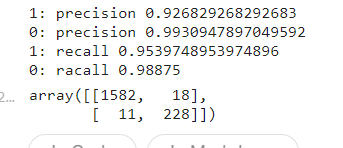


Після цього я б хотів покращити модель і для цього використав замість RNN, LSTM модель і наші результати стали ще кращими.

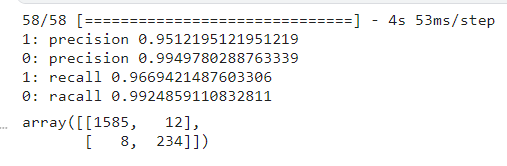

Для покращення моделі LSTM я спробував додати оптимізатор, що ще трохи покращило  результати.

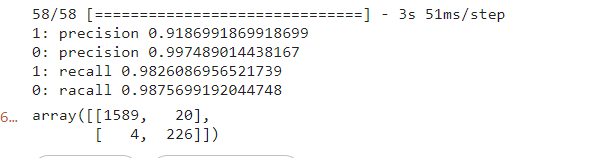

Із цього можна зробити висновок, що з самого початку ми знайшли чудову архітектуру для моделі і не обовязково було її покращувати так як моделі з LSTM не набагато покращило результати прогнозування


Після я спробував натренувати на різній розмірності простору для ембедінгу. Ненабагато але ми все таки отримали трішки гірші результати, що говорить нам про те в цілому розмірності 50 буде вистачати для прогнозування моделі